# User profiling and segmentation

## 1. Import data and check null values, column info, and descriptive statistics of the data.

In [79]:
import pandas as pd

file_path = 'user_profiles_for_ads.csv'
df = pd.read_csv(file_path)

null_values = df.isnull().sum()
info = df.info()
descriptive_stats = df.describe(include='all')

print("Null Values:\n", null_values)
print("\nColumn Info:\n", info)
print("\nDescriptive Statistics:\n", descriptive_stats)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   User ID                          1000 non-null   int64  
 1   Age                              1000 non-null   object 
 2   Gender                           1000 non-null   object 
 3   Location                         1000 non-null   object 
 4   Language                         1000 non-null   object 
 5   Education Level                  1000 non-null   object 
 6   Likes and Reactions              1000 non-null   int64  
 7   Followed Accounts                1000 non-null   int64  
 8   Device Usage                     1000 non-null   object 
 9   Time Spent Online (hrs/weekday)  1000 non-null   float64
 10  Time Spent Online (hrs/weekend)  1000 non-null   float64
 11  Click-Through Rates (CTR)        1000 non-null   float64
 12  Conversion Rates     

## 2. Begin EDA by visualizing the distribution of the key demographic variables (age, gender, education level, and income level).

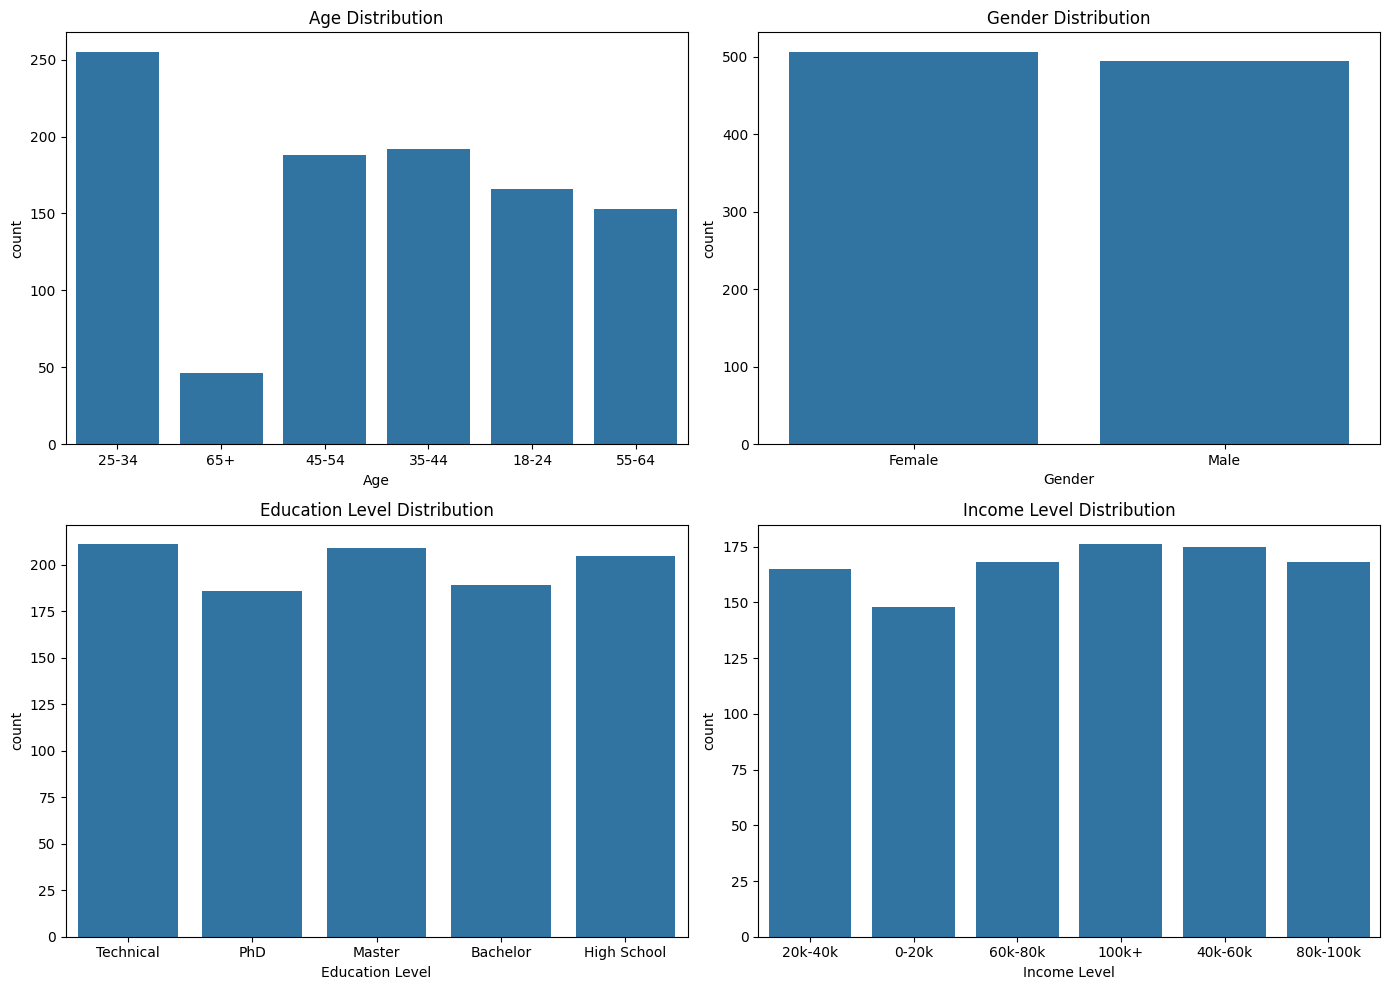

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.countplot(data=df, x='Age')
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
sns.countplot(data=df, x='Gender')
plt.title('Gender Distribution')

plt.subplot(2, 2, 3)
sns.countplot(data=df, x='Education Level')
plt.title('Education Level Distribution')

plt.subplot(2, 2, 4)
sns.countplot(data=df, x='Income Level')
plt.title('Income Level Distribution')

plt.tight_layout()
plt.show()


## 3. Examine device usage patterns to understand the primary means by which users access the platform. Also, explore users' online behavior, including their engagement with content and ads, and identify the most common interests among users.

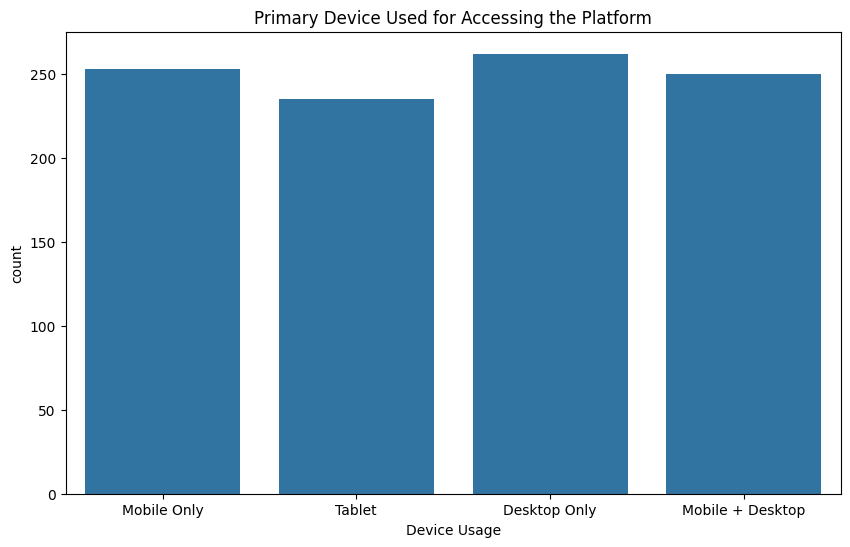

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Device Usage')
plt.title('Primary Device Used for Accessing the Platform')
plt.show()




## 4. User online Behavior and Ad interaction metrics.




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axs = plt.subplots(3, 2, figsize=(14, 12))

sns.histplot(df['Time Spent Online (hrs/weekday)'], kde=True, color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title('Time Spent Online on Weekdays')

sns.histplot(df['Time Spent Online (hrs/weekend)'], kde=True, color='orange', ax=axs[0, 1])
axs[0, 1].set_title('Time Spent Online on Weekends')

sns.histplot(df['Likes and Reactions'], kde=True, color='green', ax=axs[1, 0])
axs[1, 0].set_title('Likes and Reactions')

sns.histplot(df['Click-Through Rates (CTR)'], kde=True, color='red', ax=axs[1, 1])
axs[1, 1].set_title('Click-Through Rates (CTR)')

sns.histplot(df['Conversion Rates'], kde=True, color='purple', ax=axs[2, 0])
axs[2, 0].set_title('Conversion Rates')

sns.histplot(df['Ad Interaction Time (sec)'], kde=True, color='brown', ax=axs[2, 1])
axs[2, 1].set_title('Ad Interaction Time (sec)')

plt.tight_layout()
plt.suptitle('User Online Behavior and Ad Interaction Metrics', y=1.02, fontsize=16)
plt.show()


## 5. Identify the most common interests among users.

<ipython-input-12-45166df3626d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_interests_count.values, y=top_interests_count.index, palette="Blues_r")


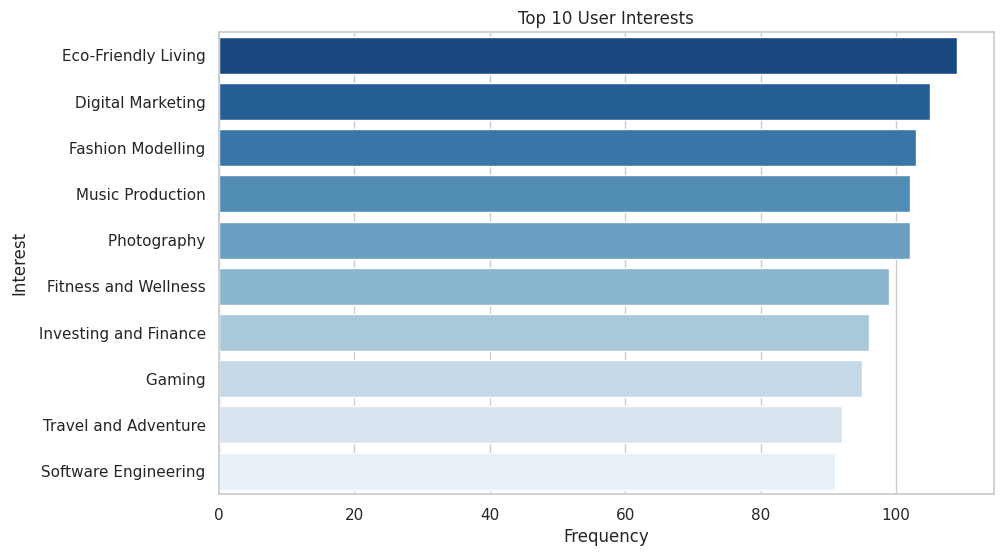

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df_exploded = df['Top Interests'].str.split(',', expand=True).stack().reset_index(level=1, drop=True)
df_exploded.name = 'Interest'

top_interests_count = df_exploded.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_interests_count.values, y=top_interests_count.index, palette="Blues_r")
plt.title('Top 10 User Interests')
plt.xlabel('Frequency')
plt.ylabel('Interest')
plt.show()


## Clean the data a bit for segmentation

In [80]:
import pandas as pd
import numpy as np

def convert_age(age_range):
    if '+' in age_range:  # Handle cases like '65+'
        return int(age_range.replace('+', ''))
    else:
        age_min, age_max = age_range.split('-')
        return (int(age_min) + int(age_max)) / 2

def convert_income(income_range):
    if '+' in income_range:  # Handle cases like '100k+'
        return int(income_range.replace('k+', '')) * 1000
    else:
        income_min, income_max = income_range.replace('k', '').split('-')
        return (int(income_min) + int(income_max)) * 1000 / 2

df['Age'] = df['Age'].apply(convert_age)
df['Income Level'] = df['Income Level'].apply(convert_income)

df[['Age', 'Income Level']].head()


,Age,Income Level
0,29.5,30000.0
1,65.0,10000.0
2,49.5,70000.0
3,39.5,100000.0
4,29.5,30000.0


## 6.  Segment users into distinct groups for targeted ad campaigns using clustering.

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

numeric_columns = ['Age', 'Income Level',
                   'Time Spent Online (hrs/weekday)', 'Time Spent Online (hrs/weekend)',
                   'Likes and Reactions', 'Click-Through Rates (CTR)',
                   'Conversion Rates', 'Ad Interaction Time (sec)']

df_encoded = pd.get_dummies(df, columns=['Gender', 'Education Level'])

selected_features = numeric_columns + [col for col in df_encoded.columns if col.startswith('Gender_') or col.startswith('Education Level_')]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded[selected_features])

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Segment'] = kmeans.fit_predict(X_scaled)

print("Cluster distribution:\n", df['Segment'].value_counts())


Cluster distribution:
 Segment
3    211
4    209
1    205
2    189
0    186
Name: count, dtype: int64


## 7. Compute the mean values of the numerical features and the mode for categorical features within each cluster.

In [96]:
mean_values = df_encoded.groupby('Segment')[selected_features].mean()

mode_values = df.groupby('Segment').agg(lambda x: x.mode()[0])

print("Mean values of numerical features per cluster:\n", mean_values)
print("\nMode values of categorical features per cluster:\n", mode_values)


Mean values of numerical features per cluster:
                Age  Income Level  Time Spent Online (hrs/weekday)  \
Segment                                                             
0        40.129032  60752.688172                         2.766129   
1        39.497561  55463.414634                         2.650732   
2        40.952381  62222.222222                         2.813757   
3        39.542654  59857.819905                         2.738389   
4        39.940191  60287.081340                         2.822967   

         Time Spent Online (hrs/weekend)  Likes and Reactions  \
Segment                                                         
0                               4.819355          4852.854839   
1                               4.529756          4913.697561   
2                               4.359259          5054.275132   
3                               4.497630          5250.355450   
4                               4.802392          4899.818182   

         Cli

## 8. Assign Each Cluster a Name Based on Its Characteristics

In [99]:

cluster_names = {
    0: "Weekend Warriors",
    1: "Engaged Professionals",
    2: "Low-Key Users",
    3: "Active Explorers",
    4: "Budget Browsers",
}

df['Segment Name'] = df['Segment'].map(cluster_names)

print(df[['Segment', 'Segment Name']].head())


   Segment      Segment Name
0        3  Active Explorers
1        0  Weekend Warriors
2        3  Active Explorers
3        0  Weekend Warriors
4        3  Active Explorers


## 9. Create a radar chart that compares the mean values of selected features across the clusters.

<ipython-input-103-e157f496e675>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10')


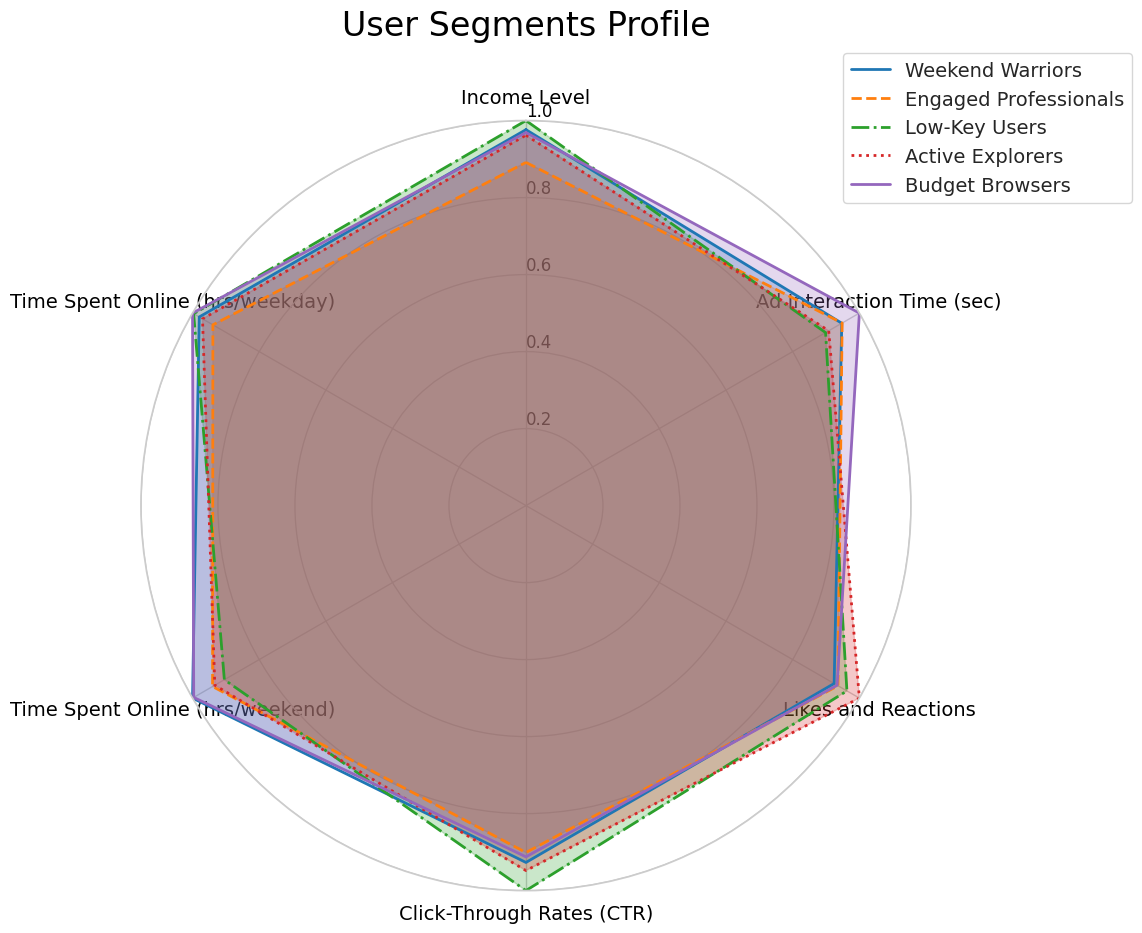

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Define the features to visualize
top_features_for_radar = ['Income Level', 'Ad Interaction Time (sec)',
                          'Likes and Reactions', 'Click-Through Rates (CTR)',
                          'Time Spent Online (hrs/weekend)', 'Time Spent Online (hrs/weekday)']

# Prepare data for the radar chart
mean_values_radar = mean_values.loc[:, top_features_for_radar]

# Normalize the data (0 to 1 scale)
mean_values_radar = mean_values_radar / mean_values_radar.max()

# Compute the angles for the radar chart
num_vars = len(top_features_for_radar)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Initialize radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each cluster
cluster_names_updated = ["Weekend Warriors", "Engaged Professionals", "Low-Key Users",
                         "Active Explorers", "Budget Browsers"]

colormap = plt.cm.get_cmap('tab10')
colors = [colormap(i) for i in range(len(cluster_names_updated))]
linestyles = ['-', '--', '-.', ':', '-']

for i, row in mean_values_radar.iterrows():
    values = row.tolist()
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, label=cluster_names_updated[i], color=colors[i], linestyle=linestyles[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.25)

# Adjust text sizes for clarity
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)
plt.xticks(angles[:-1], top_features_for_radar, color='black', size=14)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="black", size=12)
plt.ylim(0, 1)

# Add a title and legend
plt.title('User Segments Profile', size=24, color='black', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=14)

# Show the plot
plt.show()
